# Classifying blood plasma and blood serum with increasing training set size (Figure XX6)

In [1]:
import Classification_Utils as cu
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import learning_curve, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

## Load and clean data

In [3]:
df = pd.read_csv('SerumPlasmaPeptideQuant.txt', sep='\t', index_col='Peptide')
print(df.shape)

(9447, 119)


## Map each column to a corresponding label

In [4]:
tissues = ['Blood_Plasma', 'Blood_Serum']
tissues_to_columns = cu.map_tissues_to_columns(df, tissues)

In [5]:
column_names = df.columns.values.tolist()
labels = cu.get_labels(column_names, tissues_to_columns)

## Reduce dataframe to smaller number of peptides

In [15]:
import math

def keep_percentile_peptides(df, labels, tissues, percentile, impute_val):
    
    df = df.T
    tissue_dfs = []
    
    for tissue in tissues:
        cols_to_drop = [col for col in df.columns.values if not col.startswith(tissue)]
        tissue_df = df.drop(cols_to_drop, axis=1)
        
        ### Drop rows with nothing observed
        tissue_df.replace(impute_val, np.nan, inplace=True)
        tissue_df.dropna(axis=0, how='all', inplace=True)
        tissue_df.replace(np.nan, impute_val, inplace=True)
        
        peptide_mean_abundances = tissue_df.mean(axis=1) # pandas series

        # sort by average abundance value, drop below threshold
        peptide_mean_abundances.sort_values(ascending=False, inplace=True)
        num_peptides_to_keep = math.ceil(len(peptide_mean_abundances) * percentile/100)
        peptides_to_drop = peptide_mean_abundances[num_peptides_to_keep:].index.values
        
        tissue_df.drop(peptides_to_drop, axis=0, inplace=True)
        
        tissue_dfs.append(tissue_df)
        
    # join dataframes
    combined_df = pd.DataFrame()
    for next_df in tissue_dfs:
        combined_df = combined_df.join(next_df, how='outer')
    
    combined_df.replace(np.nan, impute_val, inplace=True)
        
    return combined_df.T

In [16]:
imputed_val = df.mode().iloc[0, 0]

print(df.shape)
df = keep_percentile_peptides(df.T, labels, tissues, 45, imputed_val).T
print(df.shape)

(4983, 119)
(2319, 119)


## Plot Learning Curve
Modified from http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

In [13]:
def plot_learning_curve(estimator, title, data, labels, ylim=None,
                        cv=StratifiedShuffleSplit(n_splits=100, test_size=.3, random_state=0),
                        n_jobs=1, train_sizes=[20, 30, 40, 50]):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Samples per Tissue")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, data, labels, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    print('Mean test set scores: ', test_scores_mean)
        
    plt.grid()

    plt.fill_between(train_sizes/2, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="r")
    ### Train sizes = combined plasma + serum. Divide by 2 to get size per tissue
    plt.plot(train_sizes/2, test_scores_mean, 'o-', color="r",
             label="Test Set Accuracy Score")

    return plt

In [9]:
models = [LogisticRegression(random_state=0), MultinomialNB(), RandomForestClassifier(random_state=0), SVC(kernel='linear', random_state=0), GradientBoostingClassifier(random_state=0), GaussianNB(), KNeighborsClassifier()]

model_names = ['Logistic Regression', 'Multinomial Naive Bayes', 'Random Forest', 'SVC', 
               'Gradient Boosting', 'Gaussian Naive Bayes', 'K-Nearest Neighbors']


*** Logistic Regression :
Mean test set score:  [ 0.74194444  0.80111111  0.82333333  0.83361111  0.85777778  0.86916667
  0.87805556  0.885     ]


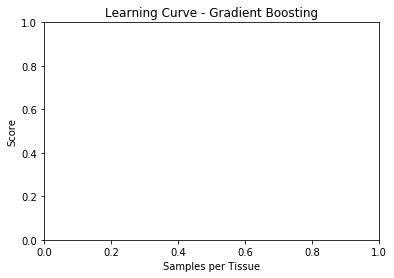

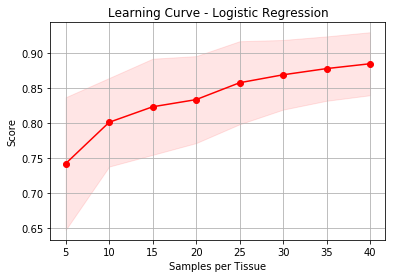


*** Multinomial Naive Bayes :
Mean test set score:  [ 0.72972222  0.77916667  0.78555556  0.78083333  0.78555556  0.78944444
  0.79944444  0.79944444]


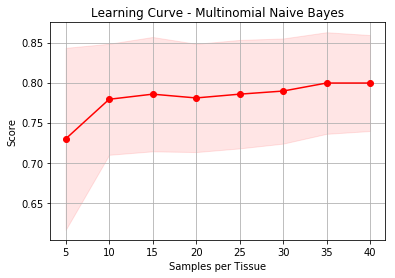


*** Random Forest :
Mean test set score:  [ 0.67194444  0.77027778  0.79888889  0.81        0.82361111  0.81944444
  0.82611111  0.83527778]


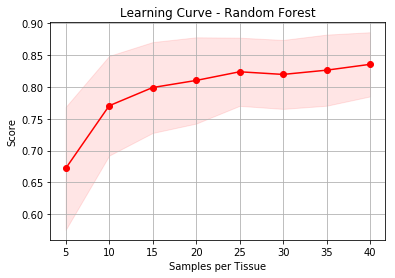


*** SVC :
Mean test set score:  [ 0.74722222  0.81861111  0.84138889  0.85111111  0.8725      0.87972222
  0.88611111  0.89388889]


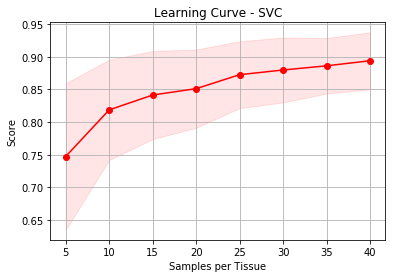


*** Gradient Boosting :
Mean test set score:  [ 0.68805556  0.74416667  0.77694444  0.78861111  0.79027778  0.79361111
  0.80083333  0.80138889]


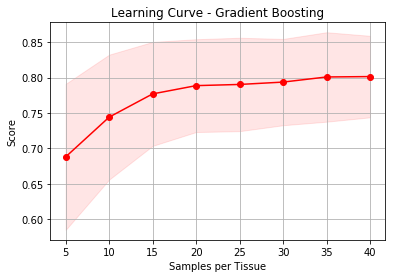


*** Gaussian Naive Bayes :
Mean test set score:  [ 0.71111111  0.7875      0.79666667  0.80083333  0.80638889  0.80666667
  0.80222222  0.79694444]


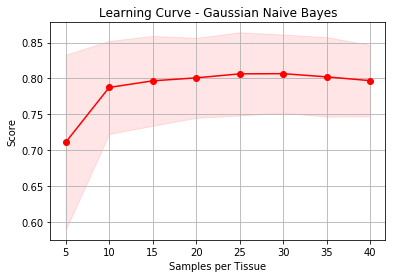


*** K-Nearest Neighbors :
Mean test set score:  [ 0.56611111  0.75638889  0.80694444  0.83027778  0.84027778  0.85444444
  0.86694444  0.88      ]


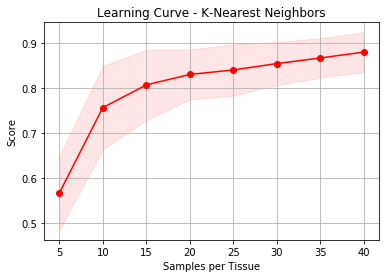

In [14]:
for clf, name in zip(models, model_names):
    print('\n***', name, ':')
    plt = plot_learning_curve(clf, 'Learning Curve - ' + name, df.T, labels, train_sizes = [10, 20, 30, 40, 50, 60, 70, 80])
    plt.show()
    plt.clf()
